<a href="https://colab.research.google.com/github/Emily-Rouse/cosc470s24/blob/Solutions/Lab5solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# example of a dcgan on cifar10
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, trainy), (_, _) = load_data()
 	# frogs are class 6
	indices = np.where(trainy == 6)
	trainX = trainX[indices[0]]
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

a = load_real_samples()

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, 50)

2/2 [==============================] - 1s 202ms/step
>1, 1/39, d1=0.692, d2=0.711 g=0.690
2/2 [==============================] - 0s 209ms/step
>1, 2/39, d1=0.456, d2=0.804 g=0.659
2/2 [==============================] - 0s 211ms/step
>1, 3/39, d1=0.135, d2=1.480 g=0.697
2/2 [==============================] - 0s 198ms/step
>1, 4/39, d1=0.138, d2=0.950 g=0.943
2/2 [==============================] - 1s 306ms/step
>1, 5/39, d1=0.428, d2=0.648 g=0.801
2/2 [==============================] - 0s 196ms/step
>1, 6/39, d1=0.319, d2=0.862 g=0.741
2/2 [==============================] - 0s 198ms/step
>1, 7/39, d1=0.142, d2=0.678 g=0.717
2/2 [==============================] - 1s 306ms/step
>1, 8/39, d1=0.171, d2=0.698 g=0.715
2/2 [==============================] - 0s 191ms/step
>1, 9/39, d1=0.088, d2=0.719 g=0.717
2/2 [==============================] - 0s 199ms/step
>1, 10/39, d1=0.025, d2=0.806 g=0.777
2/2 [==============================] - 1s 308ms/step
>1, 11/39, d1=0.057, d2=0.613 g=0.930
2/2 [===

2/2 [==============================] - 0s 196ms/step
>11, 1/39, d1=0.404, d2=0.813 g=2.632
2/2 [==============================] - 0s 188ms/step
>11, 2/39, d1=0.456, d2=0.211 g=2.307
2/2 [==============================] - 1s 315ms/step
>11, 3/39, d1=0.281, d2=2.558 g=3.400
2/2 [==============================] - 0s 195ms/step
>11, 4/39, d1=2.340, d2=0.353 g=1.188
2/2 [==============================] - 0s 195ms/step
>11, 5/39, d1=0.757, d2=0.590 g=1.037
2/2 [==============================] - 1s 292ms/step
>11, 6/39, d1=0.689, d2=0.557 g=1.085
2/2 [==============================] - 0s 212ms/step
>11, 7/39, d1=0.623, d2=0.543 g=1.043
2/2 [==============================] - 0s 211ms/step
>11, 8/39, d1=0.608, d2=0.640 g=0.950
2/2 [==============================] - 1s 222ms/step
>11, 9/39, d1=0.518, d2=0.897 g=0.951
2/2 [==============================] - 0s 191ms/step
>11, 10/39, d1=0.533, d2=0.765 g=0.931
2/2 [==============================] - 0s 199ms/step
>11, 11/39, d1=0.561, d2=0.714 g=1.0

2/2 [==============================] - 0s 191ms/step
>21, 1/39, d1=0.549, d2=1.009 g=2.031
2/2 [==============================] - 0s 204ms/step
>21, 2/39, d1=0.782, d2=0.296 g=1.704
2/2 [==============================] - 0s 196ms/step
>21, 3/39, d1=0.736, d2=0.540 g=1.241
2/2 [==============================] - 0s 191ms/step
>21, 4/39, d1=0.678, d2=0.905 g=1.404
2/2 [==============================] - 0s 203ms/step
>21, 5/39, d1=0.794, d2=0.521 g=1.418
2/2 [==============================] - 0s 196ms/step
>21, 6/39, d1=0.862, d2=0.739 g=1.084
2/2 [==============================] - 0s 222ms/step
>21, 7/39, d1=0.730, d2=0.752 g=1.000
2/2 [==============================] - 0s 194ms/step
>21, 8/39, d1=0.753, d2=0.712 g=1.045
2/2 [==============================] - 0s 200ms/step
>21, 9/39, d1=0.714, d2=0.534 g=1.243
2/2 [==============================] - 0s 193ms/step
>21, 10/39, d1=0.545, d2=0.444 g=1.514
2/2 [==============================] - 0s 194ms/step
>21, 11/39, d1=0.459, d2=0.625 g=1.4

2/2 [==============================] - 0s 195ms/step
>31, 1/39, d1=0.659, d2=0.642 g=1.108
2/2 [==============================] - 1s 312ms/step
>31, 2/39, d1=0.593, d2=0.614 g=1.046
2/2 [==============================] - 0s 189ms/step
>31, 3/39, d1=0.680, d2=0.760 g=0.956
2/2 [==============================] - 0s 194ms/step
>31, 4/39, d1=0.683, d2=0.639 g=0.975
2/2 [==============================] - 0s 192ms/step
>31, 5/39, d1=0.719, d2=0.655 g=1.040
2/2 [==============================] - 0s 189ms/step
>31, 6/39, d1=0.708, d2=0.640 g=1.056
2/2 [==============================] - 0s 194ms/step
>31, 7/39, d1=0.689, d2=0.627 g=1.108
2/2 [==============================] - 0s 196ms/step
>31, 8/39, d1=0.603, d2=0.595 g=1.082
2/2 [==============================] - 0s 188ms/step
>31, 9/39, d1=0.669, d2=0.718 g=0.989
2/2 [==============================] - 0s 192ms/step
>31, 10/39, d1=0.687, d2=0.716 g=0.951
2/2 [==============================] - 0s 192ms/step
>31, 11/39, d1=0.641, d2=0.730 g=0.9

2/2 [==============================] - 0s 212ms/step
>41, 1/39, d1=0.520, d2=0.900 g=1.043
2/2 [==============================] - 1s 311ms/step
>41, 2/39, d1=0.717, d2=0.635 g=1.140
2/2 [==============================] - 0s 189ms/step
>41, 3/39, d1=0.719, d2=0.566 g=1.059
2/2 [==============================] - 0s 195ms/step
>41, 4/39, d1=0.696, d2=0.700 g=1.030
2/2 [==============================] - 0s 215ms/step
>41, 5/39, d1=0.751, d2=0.689 g=1.048
2/2 [==============================] - 0s 195ms/step
>41, 6/39, d1=0.666, d2=0.626 g=1.008
2/2 [==============================] - 0s 198ms/step
>41, 7/39, d1=0.677, d2=0.712 g=1.110
2/2 [==============================] - 0s 196ms/step
>41, 8/39, d1=0.722, d2=0.634 g=1.065
2/2 [==============================] - 0s 196ms/step
>41, 9/39, d1=0.754, d2=0.574 g=1.090
2/2 [==============================] - 0s 197ms/step
>41, 10/39, d1=0.689, d2=0.649 g=1.071
2/2 [==============================] - 0s 195ms/step
>41, 11/39, d1=0.653, d2=0.683 g=1.0

In [ ]:
# plot the generated images
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
    # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

4/4 [==============================] - 1s 148ms/step


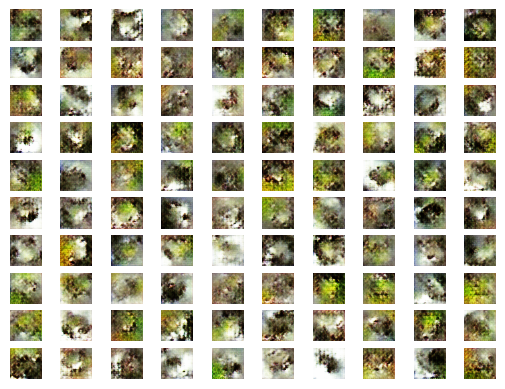

In [ ]:
# generate images
latent_points = generate_latent_points(100, 100)
X = g_model.predict(latent_points)
X = (X + 1)/ 2.0
#plot
create_plot(X, 10)